# Treine sua primeira rede neural: classificação básica

Este tutorial treina um modelo de rede neural para classificação de imagens de roupas, como tênis e camisetas. Tudo bem se você não entender todos os detalhes; este é um visão geral de um programa do TensorFlow com detalhes explicados enquanto progredimos.

O guia usa [tf.keras](https://www.tensorflow.org/guide/keras?hl=pt-br), uma API alto-nível para construir e treinar modelos no TensorFlow.

## Importar as bibliotecas

In [ ]:
# Importar o TensorFlow e o tf.keras
import tensorflow as tf
from tensorflow import keras

# Importar as bibliotecas auxiliares
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Verificar a versão do TensorFlow
print(tf.__version__)

2.8.2


## Importar a base de dados *Fashion MNIST*

O tutorial em questão usa a base de dados [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) que contém 70k imagens em tons de cinza separadas em 10 categorias. As [imagens](https://www.tensorflow.org/images/fashion-mnist-sprite.png?hl=pt-br) apresentam artigos individuais de roupas com baixa resolução (28x28 pixels).

Esse conjunto de dados tem a intenção de substituir a clássica base de dados [MNIST](http://yann.lecun.com/exdb/mnist/), conhecida por ser o **Olá, Mundo!** do aprendizado de máquina voltado a visão computacional. Essa base de dados possui imagens de dígitos numéricos escritos à mão (0 até 9) de modo semelhante ao *Fashion MNIST*.


A escolha de usar o *Fashion MNIST*, pois é um problema um pouco mais desafiador que usar somente o *MNIST*. Ambas as bases de dados são relativamente pequenas e são ótimas para avaliar se o algoritmo desenvolvido funciona como o esperado.

Serão usadas 60k imagens de treino e 10k para os testes. Essa base de dados não precisa ser baixada, basta apenas acessá-la pelo TensorFlow:

In [ ]:
# Importar a base de dados
fashion_mnist = keras.datasets.fashion_mnist

#  Separar os dados em treino e teste
(imagens_treino, rotulos_treino), (imagens_teste, rotulos_teste) = fashion_mnist.load_data()

A base de dados retorna quatro arryas NumPY:

  - Os arrays `imagens_treino` e `rotulos_treino` são destinados ao *conjunto de treinamento*, ou seja, os dados que o modelo usará para aprender.

  - Os arrays `imagens_teste` e `rotulos_teste` são destinados ao *conjunto de teste*, ou seja, os dados que o modelo usará para a validação.

As imagens são arrays NumPy de 28x28, com valores de 0 a 255. Os rótulos (alvo da classificação) são arrays com valores de 0 a 9, sendo cada rótulo correspondente a uma peça de roupa:

Rótulo|Classe
---|---
0|Camiseta (T-shirt)/Top(top)
1|Calça (Trouser)
2|Suéter (Pullover)
3|Vestidos (Dress)
4|Casaco (Coat)
5|Sandálias (Sandal)
6|Camisas (Shirt)
7|Tênis (Sneaker)
8|Bolsa (Bag)
9|Botas (Ankle boot)

Cada imagem é mapeada somente com um rótulo. Como o nome das classes não são incluídas na base de dados, vamos armazenás-las em uma lista para usá-las posteriormente:

In [ ]:
nome_classes = ['Camiseta/Top', 'Calça', 'Suéter', 'Vestidos', 'Casaco',
                'Sandálias', 'Camisas', 'Tênis', 'Bolsa', 'Botas']

## Explorar os dados

Agora vejamos o formato da base de dados antes de entregar ao modelo. O código abaixo exibe a quantidade de dados no conjunto de treino (60k imagens) e cada imagem possui a dimensão de 28x28 pixels:

In [ ]:
imagens_treino.shape

(60000, 28, 28)

Do mesmo modo, temos 60k rótulos no conjunto de treino:

In [ ]:
len(rotulos_treino)

60000

E cada rótulo é um inteiro de 0 a 9:

In [ ]:
rotulos_treino

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Como a base de dados possui 70k imagens e 60k foram destinadas para o conjunto de treinamento, há somente 10k imagens para o conjunto de teste:

In [ ]:
imagens_teste.shape

(10000, 28, 28)

E há 10k rótulos para o conjunto de teste:

In [ ]:
len(rotulos_teste)

10000

## Pré-processar os dados

Antes de treinar o modelo, os dados necessitam ser pré-processados. Se olharmos a primeira imagem do conjunto de treinamento, veremos que os valores dos pixels estão entre 0 e 255:

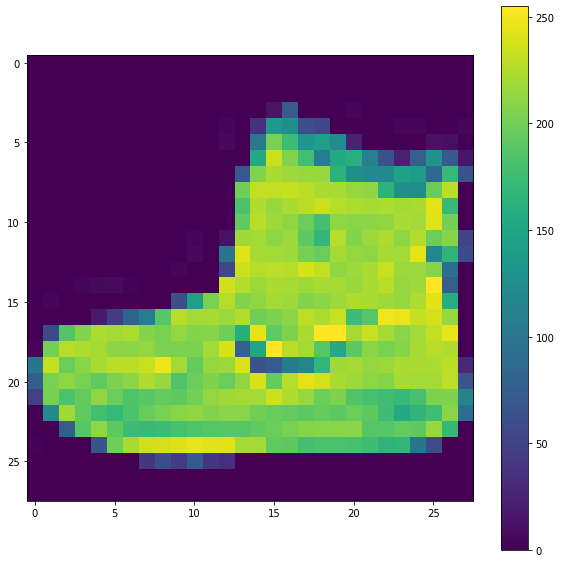

In [ ]:
# Criar a figura
plt.figure(figsize=(10, 10))

# Plotar a primeira imagem o conjunto de treino
plt.imshow(imagens_treino[0])

# Mostrar a legenda
plt.colorbar()

# Retirar a malha de fundo do gráfico
plt.grid(False)

# Mostrar a figura
plt.show()

Antes de alimentar o modelo com os dados, é necessário escalonar os valores de 0 a 255 para 0 a 1. Tanto o conjunto de treino como o de teste devem ser escalonados:

In [ ]:
# Escalonar as imagens do conjunto de treino
imagens_treino = imagens_treino / 255.0

# Escalonar as imagens do conjunto de teste
imagens_teste = imagens_teste / 255.0

Para verificar se os dados estão do modo correto e que está tudo certo para montarmos o modelo, vejamos as primeiras 25 imagens do conjunto de treino junto com o nome de cada classe:

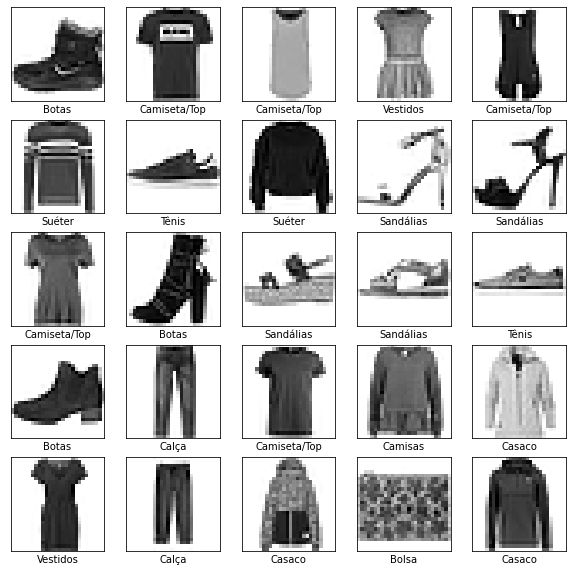

In [ ]:
# Criar a figura
plt.figure(figsize=(10, 10))

# Colocar em uma única plotagem as 25 primeiras imagens do conjunto
# de treino, sendo 5 linhas e 5 colunas
for i in range(25):
  # Colocar as imagens em uma única plotagem
  plt.subplot(5, 5, i+1)
  
  # Retirar os eixos X e Y
  plt.xticks([])
  plt.yticks([])

  # Retirar a malha de fundo do gráfico
  plt.grid(False)

  # Mostrar a imagem na plotagem em escala de cinza
  plt.imshow(imagens_treino[i], cmap=plt.cm.binary)

  # Mostrar o rótulo embaixo de cada imagem
  plt.xlabel(nome_classes[rotulos_treino[i]])

# Mostrar a figura

## Construindo o modelo

Programar um rede neural requer que as camadas do modelo sejam configuradas e, depois, compilar o modelo.

### Montar as camadas

O principal bloco de construção de uma rede neural é a camada (conhecida como *layer*). As *layers* extraem representações dos dados inseridos no modelo. Com sorte, essas representações são significativas para o problema em questão.

Muito do *deep learning* consiste em encadear simples camadas. Muitas camadas, como o módulo `tf.keras.layers.Dense`, possuem parâmetros qe são aprendidos durante o treino:

In [ ]:
# Montagem do modelo
modelo = keras.Sequential([
                           keras.layers.Flatten(input_shape=(28, 28)),
                           keras.layers.Dense(128, activation='relu'),
                           keras.layers.Dense(10, activation='softmax')
])

A primeira camada da rede, `tf.keras.layers.Flatten`, transforma o formato da imagem de um array de imagens de duas dimensões (28x28 pixels) para um array de uma dimensão (de 28x28 para 784 pixels). Essa camada não possui altura, somente largura. Essa camada não possui parâmetros para aprender, somente reformata os dados.

Depois dos pixels serem redimensionados (2D para 1D), a rede consiste de uma sequência de duas camadas `tf.keras.layers.Dense`. Essas são camadas neurais *densely connected*, ou *fully connected*. A primeira camada `Dense` possui 128 neurônios. A segunda camada é uma *softmax* de 10 neurônios que retorna um array de 10 probabilidades, cuja soma resulta em 1. Cada nó possui um valor que indica a probabilidade de que aquela imagem pertence a uma das 10 classes.

### Compilar o modelo

Antes do modelo estar pronto para o treino, é importante que algumas configurações a mais. Essas serão adicionadas na etapa de compilação:

  - *Função Loss*: Essa função mede o quão preciso é o modelo durante o treino. Queremos minimizar a função para "guiar" o modelo para a direção correta.

  - *Optimizer*: Isso é como o modelo se atualiza com base mo dados que ele vê na função *loss*.

  - *Métricas*: Usadas para monitorar os passos de treino e teste. O exemplo abaixo usa a acurácia, a fração das imagens que foram classificadas corretamente.

In [ ]:
modelo.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

## Treinar o modelo

Treinar o modelo necessita dos seguintes passos:

  1. Alimentar o modelo com os dados de treino. Em nosso estudo, os dados de treinamento são os arrays `imagens_treino` e `rotulos_treino`.
  2. O modelo aprende como associnar as imagens com os rótulos.
  3. Perguntaremos ao modelo para realizar previsões sobre o conjunto de tete. Nesse exemplo, o array `imagens_teste`. Depois disso, verificaremos se as previsões combinam com os rótulos do array `rotulos_teste`.

Para começar a treinar, chame o módulo **fit()** para que ele "encaixe" o modelo no conjunto de treino:

In [ ]:
# Treinar o modelo
modelo.fit(imagens_treino,
           rotulos_treino,
           epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4985 - accuracy: 0.8256
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3730 - accuracy: 0.8650
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3373 - accuracy: 0.8776
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3140 - accuracy: 0.8846
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2940 - accuracy: 0.8919
Epoch 6/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2801 - accuracy: 0.8963
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2671 - accuracy: 0.9004
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2562 - accuracy: 0.9043
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2476 - accuracy: 0.9073
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.237

Conforme o modelo treina, as métricas de *loss* e *acurácia* são mostradas.

## Avaliar a acurácia

Agora, precisamos avaliar como o modelo atua no conjunto de teste:

In [ ]:
# Avaliar com os dados de teste
loss_teste, acuracia_teste = modelo.evaluate(imagens_teste,
                                             rotulos_teste,
                                             verbose=2)
print('\n')
print(f'Acurácia com os dados de teste: {acuracia_teste}')

313/313 - 1s - loss: 0.3574 - accuracy: 0.8722 - 582ms/epoch - 2ms/step


Acurácia com os dados de teste: 0.8722000122070312


Como podemos ver, a acrácia no conjunto de teste é um pouco menor do que no conjunto de treino. Essa diferença ocorre por conta do *overfitting*, ou seja, o modelo é ótimo no treinamento, mas no teste ele não é tão bom.

## Realizando predições

Como o modelo já foi treinado, vamos chamá-lo para realizar predições de algumas imagens:

In [37]:
# Chamar o modelo para realizar predições
predicoes = modelo.predict(imagens_teste)

O que fizemos aqui foi pedir ao modelo que previsse qual o rótulo de cada imagem no conjunto de teste. Vejamos a previsão do primeiro item:

In [38]:
# Mostrar a previsão do primeiro item
predicoes[0]

array([5.5310062e-07, 8.5445306e-10, 2.6036406e-09, 5.2319242e-09,
       2.5515400e-08, 2.3000171e-04, 2.3233524e-06, 5.6695417e-03,
       6.9633366e-08, 9.9409747e-01], dtype=float32)

A predição, nesse caso, é um array com 10 valores. Esses valores representam a confiança do modelo que a imagem corresponde a cada uma das diferentes peças de roupa. Vejamos qual é o rótulo associado ao maior valor do array do primeiro item:

In [39]:
np.argmax(predicoes[0])

9

O que podemos ver é que o modelo confia que a imagem é uma bota ou `nome_classes[9]`. Pesquisando o rótulo de teste, vemos que é a classificação correta:

In [40]:
rotulos_teste[0]

9

Além de comparar somente o número, podemos ver essa predição em formato de gráfico. Para isso, vamos construir antes duas função da geração de gráfico:

In [57]:
def plotar_imagem(i, array_predicoes, rotulo_verdadeiro, imagem):
  """Função destinada a plotar as imagens"""
  # Variáveis
  array_predicoes = array_predicoes[i]
  rotulo_verdadeiro = rotulo_verdadeiro[i]
  imagem = imagem[i]

  # Retirar a malha de fundo do gráfico
  plt.grid(False)
  
  # Retirar os eixos X e Y
  plt.xticks([])
  plt.yticks([])

  # Mostrar a imagem em escala de cinza
  plt.imshow(imagem, cmap=plt.cm.binary)

  # Pegar qual item do array representa o rótulo
  rotulo_previsto = np.argmax(array_predicoes)

  # Se a predição for correta, pintar a legenda de azul
  if rotulo_previsto == rotulo_verdadeiro:
    cor = 'blue'
  
  # Se a predição for incorreta, pintar a legenda de vermelho
  else:
    cor = 'red'

  # Plotar a leganda na imagem
  plt.xlabel(f'{nome_classes[rotulo_previsto]} {np.max(array_predicoes):.2%} ({nome_classes[rotulo_verdadeiro]})',
             color=cor)

In [54]:
def plotar_grafico(i, array_predicoes, rotulo_verdadeiro):
  """Função destinada a plotar os gráficos"""
  # Variáveis
  array_predicoes = array_predicoes[i]
  rotulo_verdadeiro = rotulo_verdadeiro[i]

  # Retirar a malha de fundo do gráfico
  plt.grid(False)
  
  # Retirar os eixos X e Y
  plt.xticks([])
  plt.yticks([])

  # Desenhar as barras no gráfico
  # Começa com vermelho para pintar somente de azul qual é a
  # classe correta
  plotagem = plt.bar(range(10), array_predicoes, color='red')

  # Limite do eixo Y
  plt.ylim([0, 1])

  # Pegar qual item do array representa o rótulo
  rotulo_previsto = np.argmax(array_predicoes)

  # Se a previsão for correta, pintar a barra de azul
  plotagem[rotulo_verdadeiro].set_color('blue')

Vejamos a previsão do primeiro item das predições:

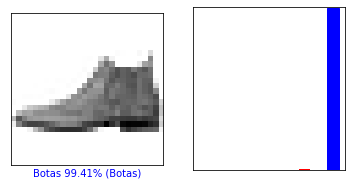

In [52]:
# Informar qual o item
i = 0

# Criar a figura
plt.figure(figsize=(6, 3))

# Indicar onde será colocada a imagem
plt.subplot(1, 2, 1)

# Plotar a imagem
plotar_imagem(i, predicoes, rotulos_teste, imagens_teste)

# Indicar onde será colocado o gráfico
plt.subplot(1, 2, 2)

# Plotar o gráfico
plotar_grafico(i, predicoes, rotulos_teste)

# Mostrar a figura
plt.show()

Vejamos com outro item:

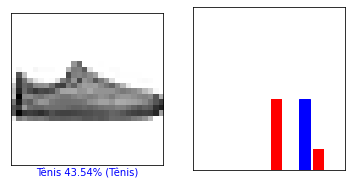

In [55]:
# Informar qual o item
i = 12

# Criar a figura
plt.figure(figsize=(6, 3))

# Indicar onde será colocada a imagem
plt.subplot(1, 2, 1)

# Plotar a imagem
plotar_imagem(i, predicoes, rotulos_teste, imagens_teste)

# Indicar onde será colocado o gráfico
plt.subplot(1, 2, 2)

# Plotar o gráfico
plotar_grafico(i, predicoes, rotulos_teste)

# Mostrar a figura
plt.show()

Como podemos ver pelas plotagens, os rótulos corretos são pintados de azul e os errados, de vermelho. Observe que o modelo erra mesmo estando confiante.

Agora vamos plotar as 15 primeiras imagens com os seus respectivos gráficos:

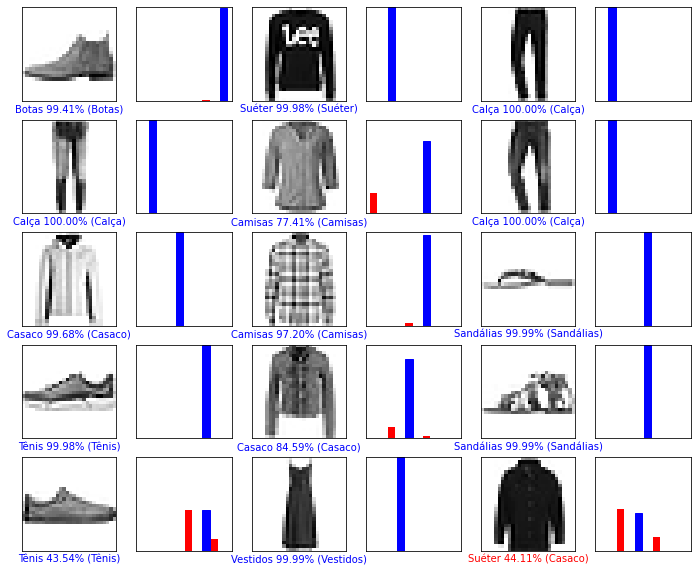

In [58]:
# Informar o número de linhas e colunas
linhas = 5
colunas = 3

# Informar o número de imagens
num_imagens = linhas*colunas

# Criar a figura
plt.figure(figsize=(2*2*colunas, 2*linhas))

# Colocar cada imagem e gráfico na figura
for i in range(num_imagens):
  plt.subplot(linhas, 2*colunas, 2*i+1)
  plotar_imagem(i, predicoes, rotulos_teste, imagens_teste)
  plt.subplot(linhas, 2*colunas, 2*i+2)
  plotar_grafico(i, predicoes, rotulos_teste)

# Mostrar a figura
plt.show()

Agora vamos usar o modelo treinado para realizar a predição de uma única imagem:

In [63]:
# Pegar a imagem do conjunto de teste
imagem = imagens_teste[0]
print(imagem.shape)

(28, 28)


Os modelos `tf.keras` são otimizados para realizar predições em lote (*batch*) ou coleções de exemplos de uma vez. Sendo assim, mesmo que seja somente uma imagem utilizada, precisamos adicionar em uma lista:

In [64]:
# Adicionar a imagem em um batch que possui somente um item
imagem = (np.expand_dims(imagem, 0))
print(imagem.shape)

(1, 28, 28)


Agora prevemos o rótulo correto para a imagem selecionada:

In [65]:
# Realizar a predição para uma única imagem
predicao_simples = modelo.predict(imagem)
print(predicao_simples)

[[5.5310062e-07 8.5444979e-10 2.6036406e-09 5.2319242e-09 2.5515352e-08
  2.3000127e-04 2.3233481e-06 5.6695463e-03 6.9633231e-08 9.9409747e-01]]


Vejamos em um gráfico com legenda qual é a classe que o modelo classificou a imagem:

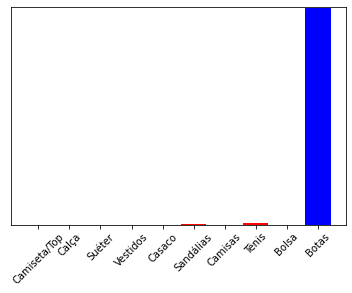

In [66]:
# Plotar o gráfico
plotar_grafico(0, predicao_simples, rotulos_teste)

# Adicionar o eixo X no gráfico
_ = plt.xticks(range(10), nome_classes, rotation=45)

O módulo `modelo.predict` retorna uma lista de listas (uma lista para cada imagem em um *batch* de dados). Selecione a predição (única) no *batch*:

In [67]:
# Ver qual é o rótulo que o modelo previu
np.argmax(predicao_simples[0])

9

E, como visto antes, o modelo previu o rótulo como 9.